<a href="https://colab.research.google.com/github/luthierman/quantum-research/blob/main/new_frozen_lake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-quantum gym

     |████████████████████████████████| 7.8MB 4.9MB/s 
     |████████████████████████████████| 92kB 4.3MB/s 
     |████████████████████████████████| 5.6MB 12.6MB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 1.5MB 25.7MB/s 
     |████████████████████████████████| 389kB 53.3MB/s 
ERROR: cirq-google 0.11.0 has requirement protobuf~=3.13.0, but you'll have protobuf 3.12.4 which is incompatible.
ERROR: tensorflow-quantum 0.5.0 has requirement grpcio==1.30.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: tensorflow-quantum 0.5.0 has requirement protobuf==3.13.0, but you'll have protobuf 3.12.4 which is incompatible.
  Found existing installation: google-auth 1.30.0
    Uninstalling google-auth-1.30.0:
      Successfully uninstalled google-auth-1.30.0
  Found existing installation: sympy 1.7.1
    Uninstalling sympy-1.7.1:
      Successfully uninstalled sympy-1.7.1
  Found 

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import gym, cirq, sympy, random
from collections import namedtuple
from copy import deepcopy
import numpy as np
Transition = namedtuple('Transition',
						('state', 'action', 'reward', 'next_state', 'done'))



def prep_angles(classical_data, qbits):
    i = 0
    ret = []
    for i,ang in enumerate(classical_data):
        rx_g = cirq.rx(np.pi*ang)
        ret.append(rx_g(qbits[i]))
        rz_g = cirq.rz(np.pi*ang)
        ret.append(rz_g(qbits[i]))
        i += 1
    a = cirq.Circuit()
    a.append(ret)
    return a

def prep_circuit(state, qbits):
    ang = decimalToBinaryFixLength(4, state)
    return tfq.convert_to_tensor([prep_angles(ang, qbits)])

In [ ]:
def one_qubit_rotation(qubit, symbols):
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]
def entangling_layer(qubits):
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    # cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops
def generate_circuit(qubits, n_layers):
    # Number of qubits
    n_qubits = len(qubits)
    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))
    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_qubits})'+f'(0:{n_layers})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))
    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))
    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))
    return circuit, list(params.flat), list(inputs.flat)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc (PQC)                    (None, 4)                 28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


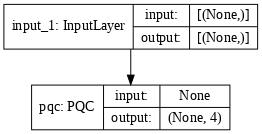

In [ ]:
#defin 4 qubit system 
n_qubits = 4
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, params, inputs = generate_circuit(qubits, 1)
n_qubits = 4
qubits = cirq.GridQubit.rect(1, n_qubits)
readout_operators = [cirq.Z(i) for i in qubits]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
quantum_model = tfq.layers.PQC(circuit, readout_operators, differentiator=tfq.differentiators.ParameterShift())(inputs)
q_model = tf.keras.Model(inputs=[inputs], outputs=[quantum_model])
q_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.99, epsilon=1e-8), loss=tf.losses.mse)
q_model.summary()
tf.keras.utils.plot_model(q_model, show_shapes=True, dpi=70)

In [ ]:
env = gym.make("FrozenLake-v0")
def make_model():
  n_actions = env.action_space.n
  input_dim = env.observation_space.n
  model = tf.keras.Sequential() 
  model.add(tf.keras.layers.Dense(64, input_dim = input_dim , activation = 'relu'))
  model.add(tf.keras.layers.Dense(32, activation = 'relu'))
  model.add(tf.keras.layers.Dense(n_actions, activation = 'linear'))
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'mse')
  return model

In [ ]:
def train(model, memory, batch_size, gamma, bits):
    minibatch = memory.sample(batch_size)
    for state, action, reward, next_state, done in minibatch:
        state = prep_circuit(state, bits)
        next_state = prep_circuit(next_state, bits)
        target_f = model.predict(state)[0]
        if done:
            target_f[action] = reward
        else:
            q_pred = np.amax(model.predict(next_state)[0])
            target_f[action] = reward + gamma*q_pred
        target_f = np.array([target_f,])
        model.fit(state, target_f, epochs=1, verbose=0)

In [ ]:
#classical train 1
random.seed(100)

def train(model,model_target, optimizer,memory, BATCH_SIZE, loss_function, GAMMA):
  minibatch = random.choices(memory,k=BATCH_SIZE)
  minibatch = Transition(*zip(*minibatch))
  next_states = [tf.one_hot(minibatch.next_state, depth=16)]
  future_rewards = model_target.predict(next_states)
  target_q_values = tf.constant(minibatch.reward) + (GAMMA * tf.reduce_max(future_rewards, axis=1)
                                                    * (1 - tf.cast(tf.constant(minibatch.done),tf.float32)))
  masks = tf.one_hot(minibatch.action, 4)
  with tf.GradientTape() as tape:
    q_values = model([tf.one_hot(minibatch.state, depth=16)])
            # Apply the masks to the Q-values
    q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            # Calculate loss between target Q-values and model Q-values
    loss = loss_function(target_q_values, q_values_masked)
  return tape, loss



In [ ]:
def train2(model,memory, BATCH_SIZE):
  minibatch = random.choices(memory,k=BATCH_SIZE)
  for state, action,reward, next_state, done in minibatch:
    state = classic_prep(state)
    next_state = classic_prep(next_state)
    target_f = model.predict(state)[0]
    if done:
      target_f[action] =reward
    else:
      q_pred = np.amax(model.predict(next_state)[0])
      target_f[action] = reward +GAMMA*q_pred
    target_f = np.array([target_f,])
    model.fit(state,target_f, epochs =1 ,verbose=0)

In [ ]:
ITERATIONS = 500 # @param {type:"integer"}
MEMORY_SIZE = 80 # @param {type:"integer"}
GAMMA = 0.999 # @param {type: "number"}
EPSILON = 1.0 # @param {type: "number"}
EPSILON_DECAY = 0.99 # @param {type: "number"}
EPSILON_MIN = 0.01 # @param {type: "number"}
UPDATE_MODEL =10 # @param {type: "integer"}
UPDATE_TARGET =30 # @param {type: "integer"}
ALPHA = .01  # @param {type: "number"}
BATCH_SIZE =   5# @param {type:"integer"}
OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate = ALPHA, rho=0.99, epsilon=1e-8) # @param {type:""}
LOSS_FUNCTION = tf.keras.losses.MeanSquaredError() # @param {type:""}

In [ ]:
def epsilon_greedy(epsilon, actions, model, state):
    if random.random() < epsilon:
        return random.randint(0, actions-1)
    else:
        return np.argmax(model.predict(state)[0])

def classic_prep(state):
  return np.array(tf.one_hot(state, depth=16)).reshape(1,-1)

In [ ]:
import os.path
from os import path
def make_path(p, d):
  print("Checking if {} exists...".format(p+d))
  if path.exists(p+d) == False:
    print("making... new directory")
    os.mkdir(p+str(d))
  print("finished!")
  print(p+str(d))
  return p+str(d)

In [ ]:
import tensorflow as tf
import numpy as np
from collections import deque
import math
env = gym.make("FrozenLake-v0")
env.seed(10)
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)
memory = deque(maxlen = MEMORY_SIZE)
cur_path = os.getcwd()
frozen_path = make_path(cur_path,"/frozen_lake")
master_path = make_path(frozen_path+"/", "classical 10^1")
windows = 50
avg_r_hist = deque(maxlen=ITERATIONS)
best_avg_reward = -math.inf
rs = deque(maxlen=windows)
model = make_model()
model_target = make_model()
model_target.set_weights(model.get_weights())
state = env.reset()
max_steps = 500
rewards = []
avg_reward = deque(maxlen=ITERATIONS)
best_avg_reward = -math.inf
rs = deque(maxlen=windows)

for i in range(ITERATIONS):
    s1 = env.reset()
    total_reward = 0
    done = False
    EPSILON = EPSILON/(i/100 + 1.)
    j = 0
    while not done:
        state1 = classic_prep(s1)
        action = epsilon_greedy(EPSILON, 4, model, state1)
        s2, reward, done, info = env.step(action)
        if j >= max_steps:
            done = True
        if reward < 0.9:
            if done:
                reward = -0.2
            else:
                reward = -0.01
        total_reward += reward
        sarnd = Transition(s1, action, reward, s2, done)
        memory.append(sarnd)
        if done and len(memory) >= BATCH_SIZE :
            tape, loss = train(model,model_target, OPTIMIZER,memory,BATCH_SIZE,LOSS_FUNCTION, GAMMA)
            grads = tape.gradient(loss, model.trainable_variables)
            OPTIMIZER.apply_gradients(zip(grads, model.trainable_variables))
        if i % UPDATE_TARGET== 0:
          model_target.set_weights(model.get_weights())
        if done:
            rewards.append(total_reward)
            rs.append(total_reward)
        else:
            s1 = s2
        j += 1
    if i >= windows:
        avg = np.mean(rs)
        avg_reward.append(avg)
        if avg > best_avg_reward:
            best_avg_reward = avg
    else: 
        avg_reward.append(-0.5)
    
    print("\rEpisode {}/{} || Best average reward {}, Current Iteration Reward {}".format(i, ITERATIONS, best_avg_reward, total_reward) , end='', flush=True)
reward_file = "{h}/rewards".format(h = master_path)
average_file = "{h}/averages".format(h=master_path)
loss_file = "{h}/loss".format(h=master_path)
np.save(reward_file , np.asarray(rewards))
np.save(average_file , np.asarray(avg_reward))

plt.ylim(0,200)
plt.plot(rewards, color='olive', label='Reward')
plt.plot(avg_reward, color='red', label='Average')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Generation')
plt.show()

Checking if /content/frozen_lake exists...
finished!
/content/frozen_lake
Checking if /content/frozen_lake/classical 10^1 exists...
making... new directory
finished!
/content/frozen_lake/classical 10^1
Episode 499/500 || Best average reward -0.2182, Current Iteration Reward -0.35

NameError: ignored

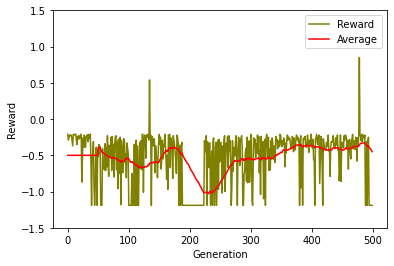

In [ ]:
import matplotlib.pyplot as plt
plt.ylim(-1.5,1.5)
plt.plot(rewards, color='olive', label='Reward')
plt.plot(avg_reward, color='red', label='Average')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Generation')
plt.show()

In [ ]:
filepath = "/content/drive/MyDrive/quantum_research/frozen_lake/classical_models/"
np.save(filepath+"reward2", np.asarray(rewards))
np.save(filepath+"avg_reward2",np.asarray(avg_reward))

In [22]:
!pip install colorama

In [ ]:
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
from collections import deque
import gym
import numpy as np
import random
import sympy
import math
import colorama
import matplotlib.pyplot as plt
def decimalToBinaryFixLength(_length, _decimal):
	binNum = bin(int(_decimal))[2:]
	outputNum = [int(item) for item in binNum]
	if len(outputNum) < _length:
		outputNum = np.concatenate((np.zeros((_length-len(outputNum),)),np.array(outputNum)))
	else:
		outputNum = np.array(outputNum)
	return outputNum

class memory(object):
    def __init__(self, length):
        self.mem = deque(maxlen=length)

    def remember(self, state, action, reward, next_state, done):
        self.mem.append((state, action, reward, next_state, done))

def prep_angles(angles, qbits):
    i = 0
    ret = []
    for ang in angles:
        rx_g = cirq.rx(np.pi*ang)
        ret.append(rx_g(qbits[i]))
        rz_g = cirq.rz(np.pi*ang)
        ret.append(rz_g(qbits[i]))
        i += 1
    a = cirq.Circuit()
    a.append(ret)
    #print(a)
    return a

def prep_circuit(state, qbits):
    ang = decimalToBinaryFixLength(4, state)
    return tfq.convert_to_tensor([prep_angles(ang, qbits)])

def layer(weights, qbits):
    ret = []
    ret.append(cirq.CNOT(qbits[0], qbits[1]))
    ret.append(cirq.CNOT(qbits[1], qbits[2]))
    ret.append(cirq.CNOT(qbits[2], qbits[3]))
    i = 0
    j = 0
    temp = []
    while i < len(qbits):
        rz_g = cirq.rz(weights[j])
        temp.append(rz_g(qbits[i]))
        i += 1
        j += 1
    ret.append(cirq.Moment(temp))
    i = 0
    temp.clear()
    while i < len(qbits):
        ry_g = cirq.ry(weights[j])
        temp.append(ry_g(qbits[i]))
        i += 1
        j += 1
    ret.append(cirq.Moment(temp))
    i = 0
    temp.clear()
    while i < len(qbits):
        rz_g2 = cirq.rz(weights[j])
        ret.append(rz_g2(qbits[i]))
        i += 1
        j += 1
    ret.append(cirq.Moment(temp))
    a = cirq.Circuit()
    a.append(ret)
    print(a)
    return a

def create_model_circuit(qubits):
    m = cirq.Circuit()
    symbols = sympy.symbols('qconv0:24') # 4 qubite * 3 weights per bit * 2 layers
    m += layer(symbols[:12], qubits)
    m += layer(symbols[12:], qubits)
    print(m)
    return m

def epsilon_greedy(g, actions, model, state):
    if random.random() < g:
        return random.randint(0, actions-1)
    else:
        return np.argmax(model.predict(state)[0])

def train(model, memory, batch_size, gamma, bits):
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        state = prep_circuit(state, bits)
        next_state = prep_circuit(next_state, bits)
        target_f = model.predict(state)[0]
        if done:
            target_f[action] = reward
        else:
            q_pred = np.amax(model.predict(next_state)[0])
            target_f[action] = reward + gamma*q_pred
        target_f = np.array([target_f,])
        model.fit(state, target_f, epochs=1, verbose=0)

bits = []
for i in range(4):
    bits.append(cirq.GridQubit(0, i))
print(bits)
readout_operators = [cirq.Z(i) for i in bits]
'''
state = np.zeros(shape=(4))
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.float32)
print(inputs)
ang = tfq.layers.AddCircuit()(inputs, prepend=prep_angles(state, bits))
quantum_model = tfq.layers.PQC(create_model_circuit(bits), readout_operators)(ang)
'''

inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
quantum_model = tfq.layers.PQC(create_model_circuit(bits), readout_operators, differentiator=tfq.differentiators.ParameterShift())(inputs)

q_model = tf.keras.Model(inputs=[inputs], outputs=[quantum_model])

q_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.99, epsilon=1e-8), loss=tf.losses.mse)

q_model.summary()

replay_memory = memory(80)

env = gym.make("FrozenLake-v0")

ITERATIONS = 500
batch_size = 5
windows = 50
explorataion = 1.0
gamma = 0.999
max_steps = 2500

print(env.action_space)
print(env.observation_space, env.observation_space.shape)
rewards = []
avg_reward = deque(maxlen=ITERATIONS)
best_avg_reward = -math.inf
rs = deque(maxlen=windows)

colorama.init()

for i in range(ITERATIONS):
    s1 = env.reset()
    total_reward = 0
    done = False
    explorataion = explorataion/(i/100 + 1.)
    j = 0
    #print(i, "exploration", explorataion)
    while not done:
        #env.render()
        state1 = prep_circuit(s1, bits)
        action = epsilon_greedy(explorataion, 4, q_model, state1)
        s2, reward, done, info = env.step(action)
        if j >= max_steps:
            done = True
        if reward < 0.9:
            if done:
                reward = -0.2
            else:
                reward = -0.01
        total_reward += reward
        replay_memory.remember(s1, action, reward, s2, done)
        #env.render()
        if len(replay_memory.mem) > batch_size and done:
            train(q_model, replay_memory.mem, batch_size, gamma, bits)
        if done:
            rewards.append(total_reward)
            rs.append(total_reward)
        else:
            s1 = s2
        j += 1
    #print(total_reward)
    if i >= windows:
        avg = np.mean(rs)
        avg_reward.append(avg)
        if avg > best_avg_reward:
            best_avg_reward = avg
    else: 
        avg_reward.append(-0.5)
    
    print("\rEpisode {}/{} || Best average reward {}, Current Iteration Reward {}".format(i, ITERATIONS, best_avg_reward, total_reward) , end='', flush=True)

plt.ylim(-0.5,1.5)
plt.plot(rewards, color='olive', label='Reward')
plt.plot(avg_reward, color='red', label='Average')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Generation')
plt.show()

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3)]
(0, 0): ───@───────────Rz(qconv0)───Ry(qconv4)───Rz(qconv8)────────
           │
(0, 1): ───X───@───────Rz(qconv1)───Ry(qconv5)───Rz(qconv9)────────
               │
(0, 2): ───────X───@───Rz(qconv2)───Ry(qconv6)───Rz(qconv10)───────
                   │
(0, 3): ───────────X───Rz(qconv3)───Ry(qconv7)───Rz(qconv11)───────
(0, 0): ───@───────────Rz(qconv12)───Ry(qconv16)───Rz(qconv20)───────
           │
(0, 1): ───X───@───────Rz(qconv13)───Ry(qconv17)───Rz(qconv21)───────
               │
(0, 2): ───────X───@───Rz(qconv14)───Ry(qconv18)───Rz(qconv22)───────
                   │
(0, 3): ───────────X───Rz(qconv15)───Ry(qconv19)───Rz(qconv23)───────
(0, 0): ───@───────────Rz(qconv0)───Ry(qconv4)───Rz(qconv8)────────@───────────Rz(qconv12)───Ry(qconv16)───Rz(qconv20)───────
           │                                                       │
(0, 1): ───X───@───────Rz(qconv1)───Ry(qconv5)───Rz(qconv9)───

In [ ]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq 
import sympy
import time
import datetime # https://stackoverflow.com/questions/10607688/how-to-create-a-file-name-with-the-current-date-time-in-python

from cirq.contrib.svg import SVGCircuit
class QDQN_alt(object):
    def __init__(self, action_space, state_space, batch, no_qubits=4, no_layers=1) -> None:
        super().__init__()
        self.action_space = action_space
        self.n_layers= no_layers
        self.state_space = state_space
        self.no_qubits = no_qubits
        self.qubits = [cirq.GridQubit(0, i) for i in range(no_qubits)]
        self.q_network = self.make_pure_model()
        
        self.learning_rate = 0.01
        self.opt = tf.keras.optimizers.Adam(lr=self.learning_rate)
        self.buff = 10000
        self.batch = batch      
        self.states = np.zeros((self.buff, self.state_space))
        self.actions = np.zeros((self.buff, 1))
        self.rewards = np.zeros((self.buff, 1))
        self.dones = np.zeros((self.buff, 1))
        self.next_states = np.zeros((self.buff, self.state_space))
        # Q Learning
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.01
        self.counter = 0
        self.date = datetime.date.today()
        self.model_name = "QDQN-{date}_qbits{q}_ADAM_lr{lr}_bs_{bs}_g{g}_eps{ep}_epsmin{epmin}_epsd{epd}".format(
            date=self.date,
            q=self.no_qubits,g=self.gamma, 
            lr=self.learning_rate,
            bs=self.batch,
            ep=self.epsilon,
            epmin=self.epsilon_min,
            epd=self.epsilon_decay)
        self.msbe = None
    def make_pure_model(self):
        readout_operators = [cirq.Z(self.qubits[i]) for i in range(2,4)]
        inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        diff = tfq.differentiators.ParameterShift()
        init = tf.keras.initializers.Zeros
        pqc = tfq.layers.PQC(self.make_circuit(self.qubits, self.n_layers), readout_operators, differentiator=diff, initializer=init)(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=pqc)
        return model

    def convert_data(self, classical_data, flag=True):
        ops = cirq.Circuit()
        for i, ang in enumerate(classical_data):
            ang = 0 if ang < 0 else 1
            ops.append(cirq.rx(np.pi * ang).on(self.qubits[i]))
            ops.append(cirq.rz(np.pi * ang).on(self.qubits[i]))
        if flag:
            return tfq.convert_to_tensor([ops])
        else:
            return ops

    def one_qubit_rotation(self, qubit, symbols):
        """
        Returns Cirq gates that apply a rotation of the bloch sphere about the X,
        Y and Z axis, specified by the values in `symbols`.
        """
        # print(symbols, "hi")
        return [cirq.rx(symbols[0])(qubit),
                cirq.ry(symbols[1])(qubit),
                cirq.rz(symbols[2])(qubit)]
    def two_qubit_rotation(self, bits, symbols):
        """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
        circuit = cirq.Circuit()
        circuit += cirq.Circuit(self.one_qubit_rotation(bits[0], symbols[0:3]))
        circuit += cirq.Circuit(self.one_qubit_rotation(bits[1], symbols[3:6]))
        circuit += [cirq.ZZ(*bits)**symbols[6]]
        circuit += [cirq.YY(*bits)**symbols[7]]
        circuit += [cirq.XX(*bits)**symbols[8]]
        circuit += cirq.Circuit(self.one_qubit_rotation(bits[0], symbols[9:12]))
        circuit += cirq.Circuit(self.one_qubit_rotation(bits[1], symbols[12:]))
        return circuit
    def entangling_layer(self, qubits):
        """
        Returns a layer of CZ entangling gates (arranged in a circular topology).
        """
        cz_ops = [cirq.CNOT(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
        cz_ops += ([cirq.CNOT(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
        return cz_ops
    def quantum_pool_circuit(self, source_bits, sink_bits, symbols):
        """A layer that specifies a quantum pooling operation.
        A Quantum pool tries to learn to pool the relevant information from two
        qubits onto 1.
        """
        circuit = cirq.Circuit()
        for source, sink in zip(source_bits, sink_bits):
            circuit += self.two_qubit_pool(source, sink, symbols)
        return circuit
    def two_qubit_pool(self, source_qubit, sink_qubit, symbols):
        pool_circuit = cirq.Circuit()
        sink_basis_selector = cirq.Circuit(self.one_qubit_rotation(sink_qubit, symbols[0:3]))
        source_basis_selector = cirq.Circuit(self.one_qubit_rotation(source_qubit, symbols[3:6]))
        pool_circuit.append(sink_basis_selector)
        pool_circuit.append(source_basis_selector)
        pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
        pool_circuit.append(sink_basis_selector**-1)
        return pool_circuit

    def make_circuit(self, qubits, n_layers):
        m = cirq.Circuit()
        n_qubits = len(qubits)
        # 4 qubits * 3 weights per bit * 3 layers + 2 * 6 pooling = 36 + 12 = 48
        params_w_pool = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits + 2*3*n_qubits//2})')
        params = params_w_pool[:-2*3*n_qubits//2] 

        params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))
        inputs = sympy.symbols(f'x(0:{n_qubits})'+f'(0:{n_layers})')
        inputs = np.asarray(inputs).reshape((n_layers, n_qubits))
        
        # print((self.two_qubit_rotation(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15'))))
        for l in range(n_layers):
        # Variational layer
            
            m += cirq.Circuit(self.one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
            m += self.entangling_layer(qubits)
            # Encoding layer
            m += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))
        
        m += cirq.Circuit(self.one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))
        # pooling
        
        pool_params = params_w_pool[-2*3*n_qubits//2:] 
        sources= qubits[:n_qubits//2]
        sinks = qubits[n_qubits//2:]
        m += self.quantum_pool_circuit(sources, sinks, pool_params)

        print(m)
        return m
    
    def remember(self, state, action, reward, next_state, done):
        i = self.counter % self.buff
        self.states[i] = state
        self.actions[i] = action
        self.rewards[i] = reward
        self.next_states[i] = next_state
        self.dones[i] = int(done)
        self.counter += 1

    def get_action(self, obs):
        if random.random() < self.epsilon: 
            return np.random.choice(self.action_space)
        else:
            return np.argmax(self.q_network.predict(self.convert_data(obs)))
    # @tf.function
    def train(self):
        batch_indices = np.random.choice(min(self.counter, self.buff), self.batch)
        state_batch = tfq.convert_to_tensor([self.convert_data(i, False) for i in self.states[batch_indices]])
        action_batch = tf.convert_to_tensor(self.actions[batch_indices], dtype=tf.int32)
        action_batch = [[i, action_batch[i][0]] for i in range(len(action_batch))]
        reward_batch = tf.convert_to_tensor(self.rewards[batch_indices], dtype=tf.float32)
        dones_batch = tf.convert_to_tensor(self.dones[batch_indices], dtype=tf.float32)
        next_state_batch = tfq.convert_to_tensor([self.convert_data(i, False) for i in self.next_states[batch_indices]])

        with tf.GradientTape() as tape:
            next_q = self.q_network(next_state_batch)
            next_q = tf.expand_dims(tf.reduce_max(next_q, axis=1), -1)
            y = reward_batch + (1 - dones_batch) * self.gamma * next_q
            q_guess = self.q_network(state_batch, training=True)
            pred = tf.gather_nd(q_guess, action_batch)
            pred = tf.reshape(pred, [self.batch, 1])
            msbe = tf.math.reduce_mean(tf.math.square(y - pred))
            self.msbe = msbe
        grads = tape.gradient(msbe, self.q_network.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.q_network.trainable_variables))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
import os.path
from os import path
def make_path(p, d):
  print("Checking if {} exists...".format(p+d))
  if path.exists(p+d) == False:
    print("making... new directory")
    os.mkdir(p+str(d))
  print("finished!")
  print(p+str(d))
  return p+str(d)

ITERATIONS = 200
windows = 50
learn_delay = 1000
qubits = 4

batch_sizes = 64
env = gym.make("CartPole-v1")
agent = QDQN_alt(env.action_space.n, env.observation_space.shape[0], batch_sizes, qubits, 1)

 
  

(0, 0): ───Rx(theta0)───Ry(theta1)────Rz(theta2)────@───────────@───Rx(x00)───Rx(theta12)───Ry(theta13)───Rz(theta14)─────────────────────────────────────────────Rx(theta27)───Ry(theta28)───Rz(theta29)───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                    │           │                                                                                                                                           │
(0, 1): ───Rx(theta3)───Ry(theta4)────Rz(theta5)────X───@───────┼───Rx(x10)───Rx(theta15)───Ry(theta16)───Rz(theta17)───────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────Rx(theta27)───Ry(theta28)───Rz(theta29)───@────────────────────────────────────────────────
                    

In [ ]:
!pip install pennylane

     |████████████████████████████████| 460kB 4.0MB/s 


In [ ]:
agent1 = QDQN_alt(env.action_space.n, env.observation_space.shape[0], batch_sizes, 4, 3)
circuit1 = agent1.make_circuit(agent1.qubits,3)
agent2 = QDQN_alt(env.action_space.n, env.observation_space.shape[0], batch_sizes, 8, 3)
circuit2 = agent1.make_circuit(agent2.qubits,3)
agent3 = QDQN_alt(env.action_space.n, env.observation_space.shape[0], batch_sizes, 12, 3)
circuit3 = agent1.make_circuit(agent3.qubits,3)

(0, 0): ───Rx(theta0)───Ry(theta1)────Rz(theta2)────@───────────@───Rx(x00)───Rx(theta12)───Ry(theta13)───Rz(theta14)───@───────────@───Rx(x11)───Rx(theta24)───Ry(theta25)───Rz(theta26)───@───────────@───Rx(x22)───Rx(theta36)───Ry(theta37)───Rz(theta38)─────────────────────────────────────────────Rx(theta51)───Ry(theta52)───Rz(theta53)───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                    │           │                                                       │           │                                                       │           │                                                                                                                                           │
(0, 1): ───Rx(theta3)───Ry(theta4)────Rz(theta5)────X───@───────┼───Rx(x01)───Rx(theta15)───Ry(theta16)───Rz(theta17)───X───@───────┼──

In [ ]:
import pennylane as qml
c1 = circuit1.to_quil()
c2 = circuit2.to_quil()
c3 = circuit3.to_quil()

In [ ]:
c3

'# Created using Cirq.\n\nRX(3.14159265358979*theta0/pi) 0\nRX(3.14159265358979*theta3/pi) 1\nRX(3.14159265358979*theta6/pi) 2\nRX(3.14159265358979*theta9/pi) 3\nRX(3.14159265358979*theta12/pi) 4\nRX(3.14159265358979*theta15/pi) 5\nRX(3.14159265358979*theta18/pi) 6\nRX(3.14159265358979*theta21/pi) 7\nRX(3.14159265358979*theta24/pi) 8\nRX(3.14159265358979*theta27/pi) 9\nRX(3.14159265358979*theta30/pi) 10\nRX(3.14159265358979*theta33/pi) 11\nRY(3.14159265358979*theta1/pi) 0\nRY(3.14159265358979*theta4/pi) 1\nRY(3.14159265358979*theta7/pi) 2\nRY(3.14159265358979*theta10/pi) 3\nRY(3.14159265358979*theta13/pi) 4\nRY(3.14159265358979*theta16/pi) 5\nRY(3.14159265358979*theta19/pi) 6\nRY(3.14159265358979*theta22/pi) 7\nRY(3.14159265358979*theta25/pi) 8\nRY(3.14159265358979*theta28/pi) 9\nRY(3.14159265358979*theta31/pi) 10\nRY(3.14159265358979*theta34/pi) 11\nRZ(3.14159265358979*theta2/pi) 0\nRZ(3.14159265358979*theta5/pi) 1\nRZ(3.14159265358979*theta8/pi) 2\nRZ(3.14159265358979*theta11/pi) 3\n